In [4]:
#get the dataset https://www.kaggle.com/mmoreaux/audio-cats-and-dogs


import librosa
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import tensorflow as tf

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# GETTING THE MAX DURATION

In [5]:
DATASET_FOLDER = "cats_dogs/"
SAMPLE_RATE = 22050

max_signal_length = 0
max_duration = 0

for file in tqdm(os.listdir(DATASET_FOLDER)):
    if '_' in file:
        file_path = os.path.join(DATASET_FOLDER, file)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        duration = len(signal)/sr
        
        if len(signal)>max_signal_length:
            max_signal_length = len(signal)
        if duration>max_duration:
            max_duration = duration
            
print(f"max signal length: {max_signal_length}")
print(f"max duration: {max_duration}")

max signal length: 396371
max duration: 17.976009070294786


In [6]:
DURATION = math.ceil(max_duration)
SAMPLES_PER_TRACK = DURATION * SAMPLE_RATE

print(f"duration after ceil:{DURATION}")
print(f"SAMPLES_PER_TRACK: {SAMPLES_PER_TRACK}")

duration after ceil:18
SAMPLES_PER_TRACK: 396900


## Defining a Padding Function

doing this because our wav files vary in length

In [8]:
def pad_signal(signal, max_length):
    data = signal
    if len(signal) < max_length:
        data = np.pad(data,(0, max(0, max_length-len(signal))))
    return data        

In [9]:
def save_mfcc(dataset_path, save_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    data = []
    num_samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)
       
    for f in tqdm(os.listdir(dataset_path)):
        if '_' in f:
            file_path = os.path.join(dataset_path, f)
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            if len(signal)<SAMPLES_PER_TRACK:
                signal = pad_signal(signal, SAMPLES_PER_TRACK) #reassign signal if it doesn't have the correct length
            
            for s in range(num_segments):
                start_sample = num_samples_per_segment * s
                finish_sample = start_sample+num_samples_per_segment
                
                mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                           sr = sr,
                                           n_fft = n_fft,
                                           n_mfcc = n_mfcc,
                                           hop_length=hop_length)
                mfcc = mfcc.T
                
                if 'cat' in f:
                    label = 0
                elif 'dog' in f:
                    label = 1
                    
                data.append((np.array(mfcc.tolist()), label))
                #print(f"{file_path}, segment: {s}")
                
        np.random.shuffle(data)
        np.save(save_path, data)
       

In [54]:
save_mfcc(DATASET_FOLDER, "data.npy")

100%|██████████| 279/279 [00:40<00:00,  6.90it/s]


In [26]:
X = []
y = []
data = np.load("data.npy", allow_pickle=True)

for feature, label in data:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print(len(X))
    

1385


In [11]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)
    #create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    #create error/loss subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [12]:
def prepare_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_test, y_train, y_test    

In [13]:
X_train, X_test, y_train, y_test = prepare_datasets(X, y)
print(X_train[0].shape)

(156, 13, 1)


In [21]:
def build_model(input_shape):
    
    model = keras.Sequential()
    
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(128, (2, 2), activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding="same"))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [22]:
input_shape = X_train[0].shape
model = build_model(input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 154, 11, 128)      1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 77, 6, 128)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 77, 6, 128)        512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 4, 128)        147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 2, 128)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 38, 2, 128)        512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 1, 128)       

Epoch 1/50
9/9 [==============================] - 1s 57ms/step - loss: 0.3765 - accuracy: 0.7563 - val_loss: 0.6392 - val_accuracy: 0.6859
Epoch 2/50
9/9 [==============================] - 0s 36ms/step - loss: 0.3976 - accuracy: 0.7245 - val_loss: 0.6328 - val_accuracy: 0.6888
Epoch 3/50
9/9 [==============================] - 0s 36ms/step - loss: 0.3948 - accuracy: 0.7331 - val_loss: 0.7317 - val_accuracy: 0.6974
Epoch 4/50
9/9 [==============================] - 0s 37ms/step - loss: 0.3936 - accuracy: 0.7428 - val_loss: 0.7210 - val_accuracy: 0.6974
Epoch 5/50
9/9 [==============================] - 0s 36ms/step - loss: 0.3936 - accuracy: 0.7418 - val_loss: 0.6393 - val_accuracy: 0.6974
Epoch 6/50
9/9 [==============================] - 0s 36ms/step - loss: 0.3787 - accuracy: 0.7428 - val_loss: 0.6373 - val_accuracy: 0.6859
Epoch 7/50
9/9 [==============================] - 0s 36ms/step - loss: 0.3875 - accuracy: 0.7370 - val_loss: 0.5964 - val_accuracy: 0.6916
Epoch 8/50
9/9 [===========

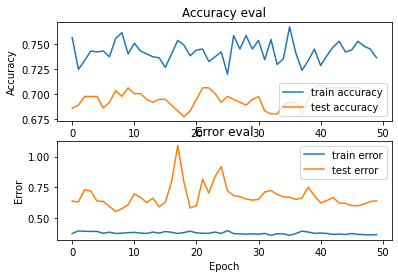

In [24]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=64, epochs=50)

test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy on test set is: {test_accuracy}")

plot_history(history)

In [25]:
X_train[0]

array([[[-1131.37084961],
        [    0.        ],
        [    0.        ],
        ...,
        [    0.        ],
        [    0.        ],
        [    0.        ]],

       [[-1131.37084961],
        [    0.        ],
        [    0.        ],
        ...,
        [    0.        ],
        [    0.        ],
        [    0.        ]],

       [[-1131.37084961],
        [    0.        ],
        [    0.        ],
        ...,
        [    0.        ],
        [    0.        ],
        [    0.        ]],

       ...,

       [[-1131.37084961],
        [    0.        ],
        [    0.        ],
        ...,
        [    0.        ],
        [    0.        ],
        [    0.        ]],

       [[-1131.37084961],
        [    0.        ],
        [    0.        ],
        ...,
        [    0.        ],
        [    0.        ],
        [    0.        ]],

       [[-1131.37084961],
        [    0.        ],
        [    0.        ],
        ...,
        [    0.        ],
        [    0.